# Rickydos/PHBS_TQFML/HW/bank_marketing

In [61]:
from sklearn import datasets
import numpy as np
import pandas as pd
bank = pd.read_csv('D:/software/2017.M3.TQF-ML/files/DataSet1/bank.csv',sep=';')
bank.replace(["unknown",'no','yes','primary','secondary','tertiary'],[np.nan,0,1,1,2,3],inplace=True)
bank.tail(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4518,57,technician,married,2.0,0,295,0,0,cellular,19,aug,151,11,-1,0,NaN,0
4519,28,blue-collar,married,2.0,0,1137,0,0,cellular,6,feb,129,4,211,3,other,0
4520,44,entrepreneur,single,3.0,0,1136,1,1,cellular,3,apr,345,2,249,7,other,0


In [62]:
bank_dummy = pd.get_dummies(bank, drop_first=True)
bank_dummy.tail(5)

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success
4516,33,2.0,0,-333,1,0,30,329,5,-1,...,0,1,0,0,0,0,0,0,0,0
4517,57,3.0,1,-3313,1,1,9,153,1,-1,...,0,0,0,0,1,0,0,0,0,0
4518,57,2.0,0,295,0,0,19,151,11,-1,...,0,0,0,0,0,0,0,0,0,0
4519,28,2.0,0,1137,0,0,6,129,4,211,...,0,0,0,0,0,0,0,0,1,0
4520,44,3.0,0,1136,1,1,3,345,2,249,...,0,0,0,0,0,0,0,0,1,0


## set dummy variable

In [63]:
bank_dummy=bank_dummy.dropna()
bank_x = bank_dummy.drop(['y'],axis=1)
from sklearn.model_selection import train_test_split
X=bank_x.values
y=bank_dummy.y.values
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [64]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train1))
print('Labels counts in y_test:', np.bincount(y_test1))

Labels counts in y: [3832  502]
Labels counts in y_train: [2682  351]
Labels counts in y_test: [1150  151]


In [65]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train1)
X_train_std1 = sc.transform(X_train1)
X_test_std1 = sc.transform(X_test1)

In [66]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

In [67]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

## select features

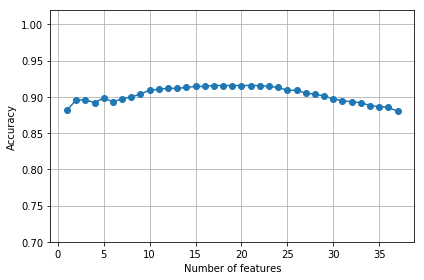

In [68]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std1, y_train1)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [69]:
k2 = list(sbs.subsets_[-2])
print(bank_x.columns[k2])

Index(['education', 'poutcome_success'], dtype='object')


## use education and poutcome_success as features

In [79]:
bank_x1 = bank_x.iloc[:,[1,-1]]
X=bank_x1.values
y=bank_dummy.y.values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [80]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [3832  502]
Labels counts in y_train: [2682  351]
Labels counts in y_test: [1150  151]


In [81]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

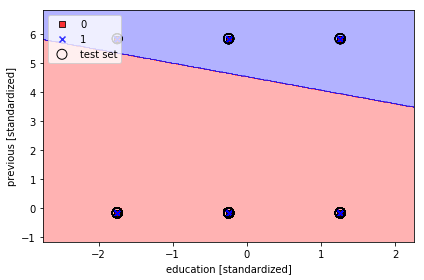

In [82]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=10.0, random_state=1)
lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(np.bincount(y_train)[0], np.bincount(y)[0]))
plt.xlabel('education [standardized]')
plt.ylabel('previous [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

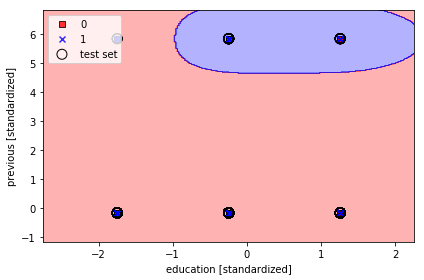

In [84]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', random_state=1, gamma=1.0, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=svm, test_idx=range(np.bincount(y_train)[0], np.bincount(y)[0]))
plt.xlabel('education [standardized]')
plt.ylabel('previous [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

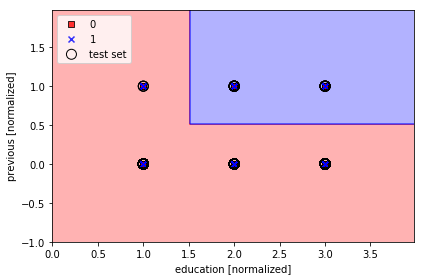

In [85]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=4, 
                              random_state=1)
tree.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree, test_idx=range(np.bincount(y_train)[0], np.bincount(y)[0]))

plt.xlabel('education [normalized]')
plt.ylabel('previous [normalized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [86]:
from sklearn.metrics import accuracy_score
y_pred_lr = lr.predict(X_test_std)
y_pred_svm = svm.predict(X_test_std)
y_pred_tree = tree.predict(X_test_std)
print('Accuracy_lr: %.2f' % accuracy_score(y_test, y_pred_lr))
print('Accuracy_svm: %.2f' % accuracy_score(y_test, y_pred_svm))
print('Accuracy_tree: %.2f' % accuracy_score(y_test, y_pred_tree))

Accuracy_lr: 0.89
Accuracy_svm: 0.89
Accuracy_tree: 0.88
